# Task 8: Fake news prediction
- The Fake News Prediction Dataset features both real and fake news, providing a
basis for predictive modeling to identify misinformation. With columns including Title, Text, and Label (Fake or Real), it addresses the pervasive issue of false or
misleading information in news.
- The dataset supports efforts to enhance information integrity, combat fake news,
and promote media literacy.

# Fake news dataset information

Fake news or hoax news is false or misleading information presented as news. Fake news often has the aim of damaging the reputation of a person or entity, or making money through advertising revenue.

This dataset is having Both Fake and Real news.

The columns present in the dataset are:-

1) `Title` -> Title of the News

2) `Text` -> Text or Content of the News

3) `Label` -> Labelling the news as Fake or Real

In [546]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import neattext.functions as nfx
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import LinearSVC
from ydata_profiling import ProfileReport
from warnings import filterwarnings

filterwarnings('ignore')
%matplotlib inline

In [547]:
# # Local PC data retrieving
# from kaggle.api.kaggle_api_extended import KaggleApi

# # Initialize the Kaggle API
# api = KaggleApi()
# api.authenticate()

# # Download the dataset
# api.dataset_download_files('rajatkumar30/fake-news', path='D:/Estiven/Datos/Proyectos/CognoRise_Infotech/data/raw', unzip=True)

# Read the data as a pandas dataframe
df = pd.read_csv("D:/Estiven/Datos/Proyectos/CognoRise_Infotech/data/raw/news.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)

In [548]:
# # Google Colab data retrieving
# from google.colab import files

# # Uploading the Kaggle API key (kaggle.json) to Colab
# files.upload()

# # Move the uploaded file to the required location of Colab
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d rajatkumar30/fake-news #dataset download
# !unzip -q creditcardfraud.zip #unzipping the data

# df = pd.read_csv("news.csv") #reading data as pandas dataframe

In [549]:
print('Simple description of the data columns:')
df.describe()

Simple description of the data columns:


,title,text,label
count,6335,6335,6335
unique,6256,6060,2
top,OnPolitics | 's politics blog,"Killing Obama administration rules, dismantlin...",REAL
freq,5,58,3171


In [550]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   object
dtypes: object(3)
memory usage: 148.6+ KB


In [551]:
# report = ProfileReport(df)
# report

# EDA, (Exploratory data analysis)

In [552]:
df.head(3)

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL


Information about nulls, infinite values and duplicates

In [553]:
nulls = df.isnull()
null_rows, null_cols = np.where(nulls)

print(f'Total of null data: {df.isnull().sum().sum()}')
print(f'Total of duplicated data: {df.duplicated().sum()}')

print(f'Rows with null values: {null_rows.sum()}')
print(f'Columns with null values: {null_cols.sum()}')

Total of null data: 0
Total of duplicated data: 29
Rows with null values: 0
Columns with null values: 0


In [554]:
duplicated_rows = df.duplicated()

print(f'Percentage of total duplicated data: {duplicated_rows.mean() * 100:.1f}%')

# Eliminating duplicated data
df = df.copy().drop_duplicates()

Percentage of total duplicated data: 0.5%


In [555]:
print(f'Data by label: {df.label.value_counts()}')

# Treatment to change real for 0 and fake for 1
df.label = df.label.map({'REAL': 0, 'FAKE': 1})
print(df.label.unique())

Data by label: label
REAL    3154
FAKE    3152
Name: count, dtype: int64
[1 0]


# Text cleaning

The title might not be that important when deciding if a new is fake or not, so I will delete it

In [556]:
df = df.copy().drop(['title'], axis=1)

In [557]:
df['text_length'] = df['text'].apply(len)
df['text_num_capital_letters'] = df['text'].apply(lambda s: sum([1 for c in s if c.isupper()]))
df['text_num_words'] = df['text'].apply(lambda s: len(s.split()))
df['text_avg_word_length'] = df['text'].apply(lambda s: sum(len(word) for word in s.split()) / len(s.split()) if len(s.split()) > 0 else 0)
df['text_num_special_chars'] = df['text'].apply(lambda s: sum([1 for c in s if not c.isalnum() and not c.isspace()]))

df.head()

,text,label,text_length,text_num_capital_letters,text_num_words,text_avg_word_length,text_num_special_chars
0,"Daniel Greenfield, a Shillman Journalism Fello...",1,7518,314,1296,4.776235,147
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,1,2646,96,446,4.917040,78
2,U.S. Secretary of State John F. Kerry said Mon...,0,2543,96,431,4.883991,55
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1,2660,139,404,5.554455,98
4,It's primary day in New York and front-runners...,0,1840,77,317,4.776025,65


In [558]:
def clean_text(text):
    text = str(text).lower()
    text = nfx.remove_special_characters(text)
    text = nfx.remove_stopwords(text)
    text = nfx.remove_urls(text)
    text = nfx.remove_puncts(text)
    text = nfx.remove_emails(text)
    text = nfx.remove_userhandles(text)
    return text

df['cleaned_text'] = df['text'].apply(clean_text)
df.drop(['text'], axis=1, inplace=True)
df.head()

,label,text_length,text_num_capital_letters,text_num_words,text_avg_word_length,text_num_special_chars,cleaned_text
0,1,7518,314,1296,4.776235,147,daniel greenfield shillman journalism fellow f...
1,1,2646,96,446,4.917040,78,google pinterest digg linkedin reddit stumbleu...
2,0,2543,96,431,4.883991,55,secretary state john f kerry said monday stop ...
3,1,2660,139,404,5.554455,98,kaydee king kaydeeking november 9 2016 lesson ...
4,0,1840,77,317,4.776025,65,primary day new york frontrunners hillary clin...


In [559]:
report_new_data = ProfileReport(df)
report_new_data

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

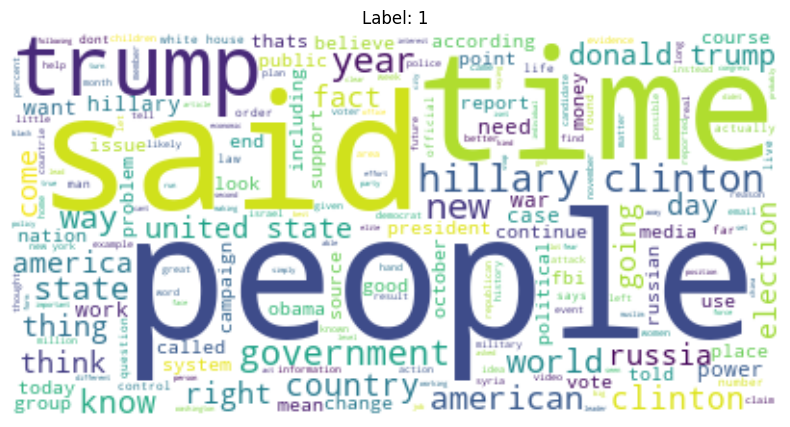

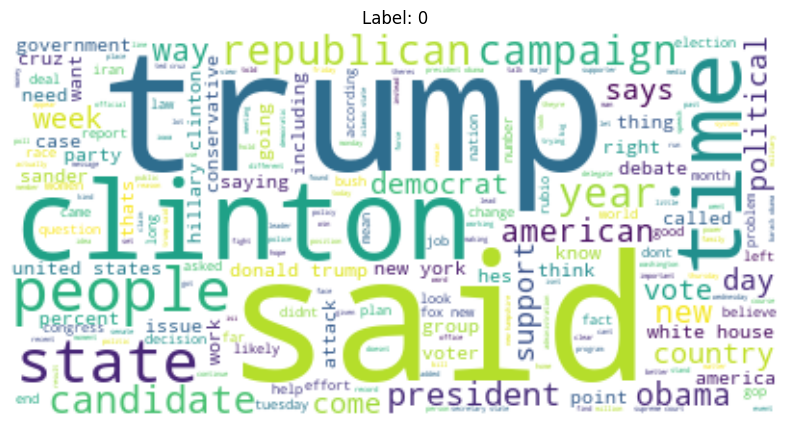

In [563]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming 'label' is the name of your label column
labels = df['label'].unique()

for label in labels:
    text = " ".join(review for review in df[df['label'] == label]['cleaned_text'])
    wordcloud = WordCloud(background_color='white').generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Label: {label}')
    plt.show()

# Model implementation

In [560]:
# Split the dataset into features (X) and target variable (y)
X = df.drop('label', axis=1)
y = df['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Best parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 300}
Cross validation scores: [0.82159848 0.85585157 0.83824929]


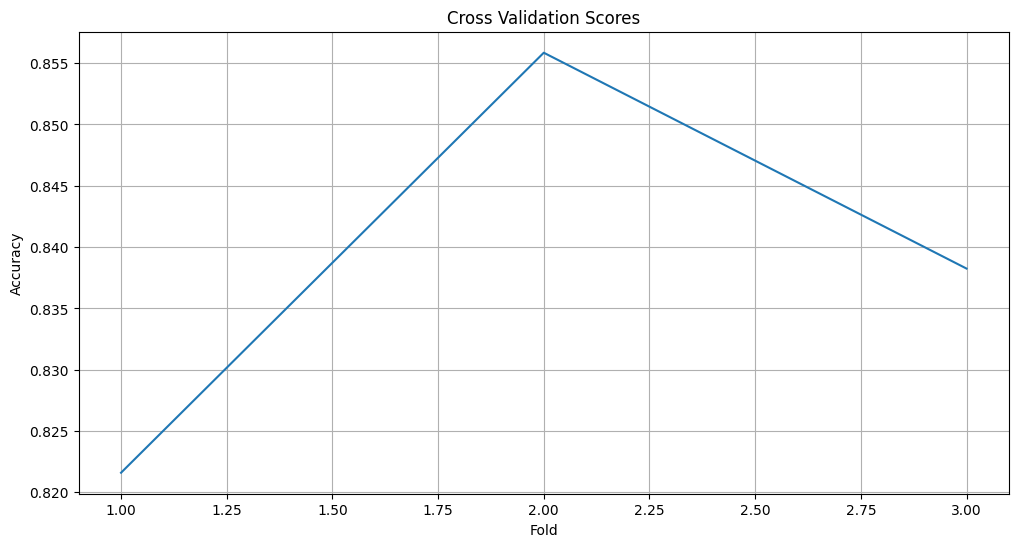

              precision    recall  f1-score   support

           0       0.90      0.77      0.83       958
           1       0.80      0.91      0.85       934

    accuracy                           0.84      1892
   macro avg       0.85      0.84      0.84      1892
weighted avg       0.85      0.84      0.84      1892



In [562]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define function to select text columns
def get_text_data(df):
    return df['cleaned_text']

# Define function to select numerical columns
def get_numeric_data(df):
    return df.drop(['cleaned_text'], axis=1)

# Define preprocessing steps
text_features = Pipeline([
    ('selector', FunctionTransformer(get_text_data, validate=False)),
    ('vectorizer', TfidfVectorizer())
])

numeric_features = Pipeline([
    ('selector', FunctionTransformer(get_numeric_data, validate=False)),
    ('scaler', RobustScaler())
])

# Combine text and numeric processing steps
preprocess = FeatureUnion(transformer_list=[
    ('text_features', text_features),
    ('numeric_features', numeric_features)
])

# Define model
model = RandomForestClassifier()

# Create pipeline
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('classifier', model)
])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define hyperparameters to tune
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [1, 5, 10],
    }

# Define scorer
scorer = make_scorer(accuracy_score)

# Create GridSearchCV object
grid = GridSearchCV(pipeline, param_grid, scoring=scorer, cv=3)

# Fit and tune model
grid.fit(X_train, y_train)

# Get best parameters
best_params = grid.best_params_
print(f"Best parameters: {best_params}")

# Get cross validation scores
cv_scores = cross_val_score(grid, X, y, cv=3)

# Print cross validation scores
print(f"Cross validation scores: {cv_scores}")

# Plot cross validation scores
plt.figure(figsize=(12, 6))
plt.plot(range(1, 4), cv_scores)
plt.title('Cross Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Evaluate model
predictions = grid.predict(X_test)
print(classification_report(y_test, predictions))